# Machine Learning Workshop - Binus

Source: 
- https://www.ritchieng.com/machine-learning-project-customer-segments/#
- https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68

## Outline

In this section of the course we will learn how to use library for create group of a data. In this section of the course, you should go through the notebooks in this order:

Data preparation:
- Load library
- Load data
- Simple EDA
- Data Transformation (Log Natural transform)
- Principal Component Analysis (Dimension Reduction)

Algorithm:
- Intro to Cluster analysis
- Cluster Alogritm: K-Means
- Cluster Alogritm: DBSCAN
- Cluster Alogritm: Gaussian Mixture Models (GMM)
- Cluster Alogritm: Agglomerative Hierarchical Clustering


# Data Preparation

## Import library

In [0]:
!curl https://raw.githubusercontent.com/afif2100/ds-workshop/master/renders.py --output renders.py -s

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import renders as rs

## Load data

The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories


Attribute Information:

- FRESH: annual spending (m.u.) on fresh products (Continuous)
- GROCERY: annual spending (m.u.)on grocery products (Continuous)
- FROZEN: annual spending (m.u.)on frozen products (Continuous) 
- DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous) 
- DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous) 
- CHANNEL: customers Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal) 
- REGION: customers Region “ Lisnon, Oporto or Other (Nominal) 

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/afif2100/ds-workshop/master/Wholesale%20customers%20data.csv')

In [11]:
data.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

In [12]:
data.sample(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
67,2,3,19913,6759,13462,1256,5141,834
243,1,1,11210,3576,5119,561,1682,2398
45,2,3,5181,22044,21531,1740,7353,4985
420,1,3,4456,5266,13227,25,6818,1393
127,2,3,21465,7243,10685,880,2386,2749


## Select only important variables

In [13]:
df = data[{'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'}]
df.head(5)

,Frozen,Milk,Delicassen,Detergents_Paper,Grocery,Fresh
0,214,9656,1338,2674,7561,12669
1,1762,9810,1776,3293,9568,7057
2,2405,8808,7844,3516,7684,6353
3,6404,1196,1788,507,4221,13265
4,3915,5410,5185,1777,7198,22615


### Get sample data

In [14]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [43, 12, 39]

# Create a DataFrame of the chosen samples
# .reset_index(drop = True) resets the index from 0, 1 and 2 instead of 100, 200 and 300 
samples = pd.DataFrame(data.loc[indices], columns = df.columns).reset_index(drop = True)
samples

,Frozen,Milk,Delicassen,Detergents_Paper,Grocery,Fresh
0,787,11095,72,9529,23998,630
1,287,12319,2931,3881,11757,31714
2,10002,555,2916,212,902,56159


# Simple EDA

In [0]:
# import pandas_profiling
# report = pandas_profiling.ProfileReport(df)

In [16]:
stats = df.describe()
stats

,Frozen,Milk,Delicassen,Detergents_Paper,Grocery,Fresh
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,3071.931818,5796.265909,1524.870455,2881.493182,7951.277273,12000.297727
std,4854.673333,7380.377175,2820.105937,4767.854448,9503.162829,12647.328865
min,25.000000,55.000000,3.000000,3.000000,3.000000,3.000000
25%,742.250000,1533.000000,408.250000,256.750000,2153.000000,3127.750000
50%,1526.000000,3627.000000,965.500000,816.500000,4755.500000,8504.000000
75%,3554.250000,7190.250000,1820.250000,3922.000000,10655.750000,16933.750000
max,60869.000000,73498.000000,47943.000000,40827.000000,92780.000000,112151.000000


## Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

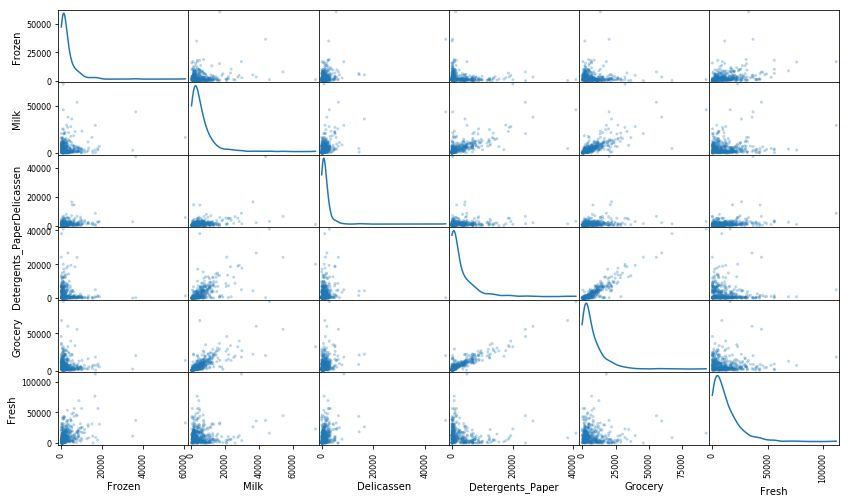

In [17]:
pd.plotting.scatter_matrix(df, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

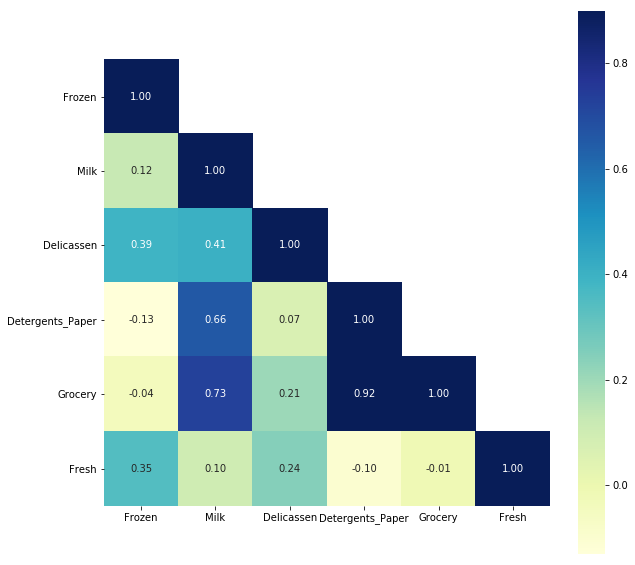

In [18]:
columns  = df.columns 
corrMatt = df[columns].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatt, mask=mask,vmax=0.9, square=True,annot=True, fmt = ".2f",cmap="YlGnBu")

### what we've got ?
I have plotted a correlation matrix to compare with the scatter matrix to ensure this answer is as accurate as possible.

The follow pairs of features seem to have some correlation as observed from the scatter plot showing a linear trend and the correlation plot showing a high correlation between the two features. I have ranked them in order of correlation from strongest to weakest.
- Grocery and Detergents_Paper.
- Grocery and Milk.
- Detergents_Paper and Milk (not too strong).

These features that are strongly correlated does lend credence to our initial claim that Grocery may not be necessary for identifying customers' spending habits.
- Grocery has a high correlation with Detergents_Paper and Milk that corresponds to a relatively high R2 score when we regress Grocery on all other features.

The data are not normally distributed due to the presence of many outliers.
- Evidently, most are skewed to the left where most of the data points lie.
- This indicates how normalization is required to make the data features normally distributed as clustering algorithms require them to be normally distributed.

# Then We need to Pre Process the data!

If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most often appropriate to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a Box-Cox test, which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

## Log Normalization

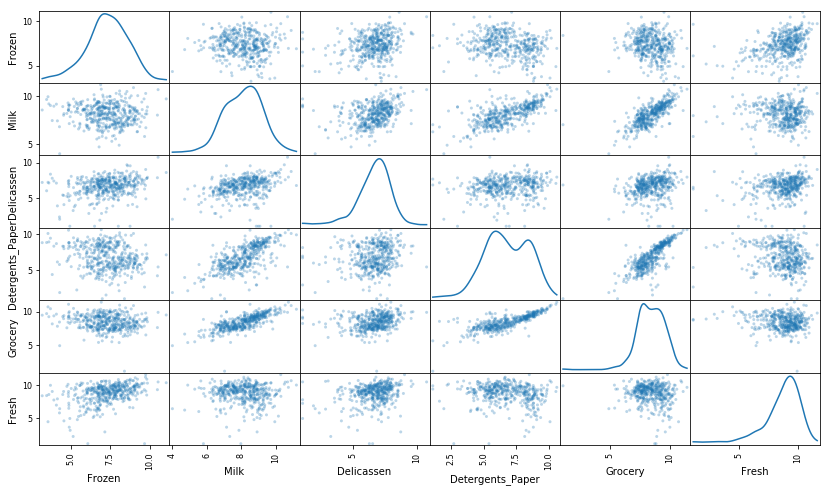

In [19]:
# TODO: Scale the data using the natural logarithm
log_df = np.log(df)

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(log_df, alpha = 0.3, figsize = (14,8), diagonal = 'kde');


# Remove outlier if needed

In [0]:
import itertools

In [21]:
# Select the indices for data points you wish to remove
outliers_lst  = []

# For each feature find the data points with extreme high or low values
for feature in log_df.columns:
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_df.loc[:, feature], 25)

    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_df.loc[:, feature], 75)

    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)

    # Display the outliers
    print(("Data points considered outliers for the feature '{}':".format(feature)))

    # The tilde sign ~ means not
    # So here, we're finding any points outside of Q1 - step and Q3 + step
    outliers_rows = log_df.loc[~((log_df[feature] >= Q1 - step) & (log_df[feature] <= Q3 + step)), :]
#     display(outliers_rows)

    outliers_lst.append(list(outliers_rows.index))

outliers = list(itertools.chain.from_iterable(outliers_lst))

# List of unique outliers
# We use set()
# Sets are lists with no duplicate entries
uniq_outliers = list(set(outliers))

# List of duplicate outliers
dup_outliers = list(set([x for x in outliers if outliers.count(x) > 1]))

print('Outliers list:\n', uniq_outliers)
print('Length of outliers list:\n', len(uniq_outliers))

print('Duplicate list:\n', dup_outliers)
print('Length of duplicates list:\n', len(dup_outliers))

# Remove duplicate outliers
# Only 5 specified
good_data = log_df.drop(log_df.index[dup_outliers]).reset_index(drop = True)

# Original Data 
print('Original shape of data:\n', df.shape)
# Processed Data
print('New shape of data:\n', good_data.shape)

Data points considered outliers for the feature 'Frozen':
Data points considered outliers for the feature 'Milk':
Data points considered outliers for the feature 'Delicassen':
Data points considered outliers for the feature 'Detergents_Paper':
Data points considered outliers for the feature 'Grocery':
Data points considered outliers for the feature 'Fresh':
Outliers list:
 [128, 264, 137, 142, 145, 154, 412, 285, 289, 161, 420, 38, 171, 429, 175, 304, 305, 439, 184, 57, 183, 187, 65, 66, 193, 325, 203, 75, 81, 338, 86, 343, 218, 95, 96, 353, 98, 355, 356, 357, 233, 109]
Length of outliers list:
 42
Duplicate list:
 [128, 65, 66, 75, 154]
Length of duplicates list:
 5
Original shape of data:
 (440, 6)
New shape of data:
 (435, 6)


# Feature Transformation

## PCA overview

In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

In [0]:
from sklearn.decomposition import PCA

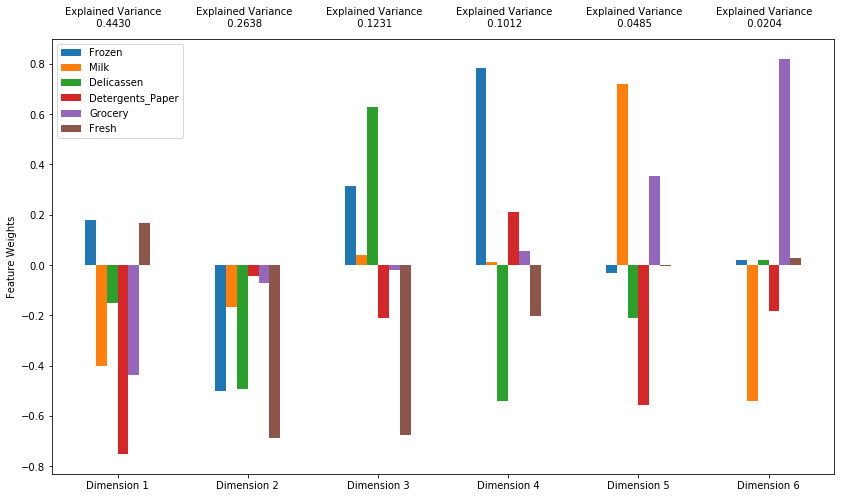

In [23]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
# Instantiate
pca = PCA(n_components=6)

# Fit
pca.fit(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

In [53]:
# DataFrame of results
display(pca_results)

# DataFrame
display(type(pca_results))

# Cumulative explained variance should add to 1
display(pca_results['Explained Variance'].cumsum())

,Explained Variance,Frozen,Milk,Delicassen,Detergents_Paper,Grocery,Fresh
Dimension 1,0.4430,0.1782,-0.4014,-0.1499,-0.7514,-0.4381,0.1675
Dimension 2,0.2638,-0.5005,-0.1672,-0.4941,-0.0424,-0.0707,-0.6859


pandas.core.frame.DataFrame

Dimension 1    0.4430
Dimension 2    0.7068
Name: Explained Variance, dtype: float64

## PCA implementation

When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the cumulative explained variance ratio is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:

- Assign the results of fitting PCA in two dimensions with good_data to pca.
- Apply a PCA transformation of good_data using pca.transform, and assign the reuslts to reduced_data.
- Apply a PCA transformation of the sample log-data log_samples using pca.transform, and assign the results to pca_samples.

In [0]:
# TODO: Apply PCA by fitting the good data with only two dimensions
# Instantiate
pca = PCA(n_components=2)
pca.fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

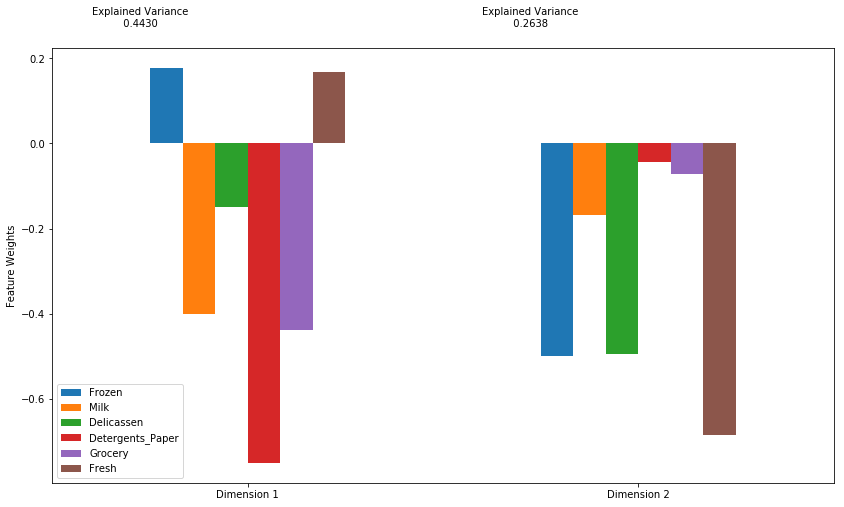

In [26]:
# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

In [27]:
# DataFrame of results
display(pca_results)

# DataFrame
display(type(pca_results))

# Cumulative explained variance should add to 1
display(pca_results['Explained Variance'].cumsum())

,Explained Variance,Frozen,Milk,Delicassen,Detergents_Paper,Grocery,Fresh
Dimension 1,0.4430,0.1782,-0.4014,-0.1499,-0.7514,-0.4381,0.1675
Dimension 2,0.2638,-0.5005,-0.1672,-0.4941,-0.0424,-0.0707,-0.6859


pandas.core.frame.DataFrame

Dimension 1    0.4430
Dimension 2    0.7068
Name: Explained Variance, dtype: float64

In [28]:
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
reduced_data.head(5)

,Dimension 1,Dimension 2
0,-1.757983,0.009711
1,-1.788665,-0.812251
2,-1.883353,-1.599135
3,1.155265,-1.405201
4,-0.784786,-2.394294


# Intro To cluster

Clustering is one of the most common exploratory data analysis technique used to get an intuition about the structure of the data. It can be defined as the task of identifying subgroups in the data such that data points in the same subgroup (cluster) are very similar while data points in different clusters are very different. In other words, we try to find homogeneous subgroups within the data such that data points in each cluster are as similar as possible according to a similarity measure such as euclidean-based distance or correlation-based distance. The decision of which similarity measure to use is application-specific.


Machine Learning can be broadly classified into 2 types:
- Supervised Learning — Where a response variable Y is present. Here there could be 2 goals, 1. Find f(X)=Y, such that f(X) closely approximates Y or 2. Predicting the value of Y given X.Usually, Regression, Decision trees, Random Forest, SVM, Naive Bayes etc.are used for these kind of problems


- Unsupervised Learning — Where there is no response variable Y and the aim is to identify the clusters with in the data based on similarity with in the cluster members. Different algorithms like K-means, Hierarchical, PCA,Spectral Clustering, DBSCAN Clustering etc. are used for these problems

## Kmeans Cluster

K-Means is probably the most well know clustering algorithm. It’s taught in a lot of introductory data science and machine learning classes. It’s easy to understand and implement in code! Check out the graphic below for an illustration.

![Kmeans](https://miro.medium.com/max/960/1*KrcZK0xYgTa4qFrVr0fO2w.gif "Kmeans Ilustration")


1. To begin, we first select a number of classes/groups to use and randomly initialize their respective center points. To figure out the number of classes to use, it’s good to take a quick look at the data and try to identify any distinct groupings. The center points are vectors of the same length as each data point vector and are the “X’s” in the graphic above.

2. Each data point is classified by computing the distance between that point and each group center, and then classifying the point to be in the group whose center is closest to it.
3. Based on these classified points, we recompute the group center by taking the mean of all the vectors in the group.
4. Repeat these steps for a set number of iterations or until the group centers don’t change much between iterations. You can also opt to randomly initialize the group centers a few times, and then select the run that looks like it provided the best results.
5. K-Means has the advantage that it’s pretty fast, as all we’re really doing is computing the distances between points and group centers; very few computations! It thus has a linear complexity O(n).

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [30]:
# Create range of clusters 
range_n_clusters = list(range(2,16))
print(range_n_clusters)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


### Find best numbers of a cluster: 
https://en.wikipedia.org/wiki/Silhouette_(clustering)

In [31]:
# Loop through clusters
for n_clusters in range_n_clusters:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_clusters=n_clusters).fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='euclidean')
    print("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

For n_clusters = 2. The average silhouette_score is : 0.4262810154691083
For n_clusters = 3. The average silhouette_score is : 0.3971382088445873
For n_clusters = 4. The average silhouette_score is : 0.3312459160606664
For n_clusters = 5. The average silhouette_score is : 0.3509907789312652
For n_clusters = 6. The average silhouette_score is : 0.3644701202046943
For n_clusters = 7. The average silhouette_score is : 0.3648753591099507
For n_clusters = 8. The average silhouette_score is : 0.364577560751949
For n_clusters = 9. The average silhouette_score is : 0.3416383508656439
For n_clusters = 10. The average silhouette_score is : 0.3508258107402663
For n_clusters = 11. The average silhouette_score is : 0.36317346544218493
For n_clusters = 12. The average silhouette_score is : 0.3686724378674057
For n_clusters = 13. The average silhouette_score is : 0.34837674683372316
For n_clusters = 14. The average silhouette_score is : 0.3621143689639956
For n_clusters = 15. The average silhouette_s

## Visualize The cluster

In [0]:
# Extra code because we ran a loop on top and this resets to what we want
clusterer = KMeans(n_clusters=2).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.cluster_centers_
sample_preds = clusterer.predict(reduced_data)

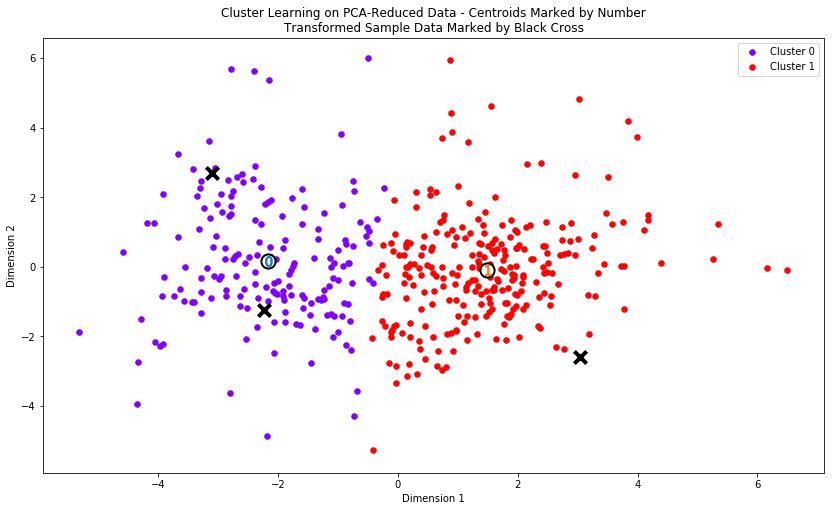

In [33]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

# Clustering using Gaussian Mixture Models (GMM)

In [0]:
# Imports
from sklearn.mixture import GaussianMixture as GMM

In [35]:
range_n_clusters

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [36]:
# Loop through clusters
for n_clusters in range_n_clusters:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = GMM(n_components=n_clusters).fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.means_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='mahalanobis')
    print("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

For n_clusters = 2. The average silhouette_score is : 0.37615565776759097
For n_clusters = 3. The average silhouette_score is : 0.38077986223763427
For n_clusters = 4. The average silhouette_score is : 0.2953280542289306
For n_clusters = 5. The average silhouette_score is : 0.3249865500632734
For n_clusters = 6. The average silhouette_score is : 0.30743228899617436
For n_clusters = 7. The average silhouette_score is : 0.31670032774063206
For n_clusters = 8. The average silhouette_score is : 0.25944874907437715
For n_clusters = 9. The average silhouette_score is : 0.2987028213441394
For n_clusters = 10. The average silhouette_score is : 0.30326803295895144
For n_clusters = 11. The average silhouette_score is : 0.3195811661481253
For n_clusters = 12. The average silhouette_score is : 0.32649138298619046
For n_clusters = 13. The average silhouette_score is : 0.2870909865856893
For n_clusters = 14. The average silhouette_score is : 0.3132172569496169
For n_clusters = 15. The average silhou

## Visualize the cluster

In [0]:
# Extra code because we ran a loop on top and this resets to what we want
clusterer = GMM(n_components=2).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_
sample_preds = clusterer.predict(pca_samples)

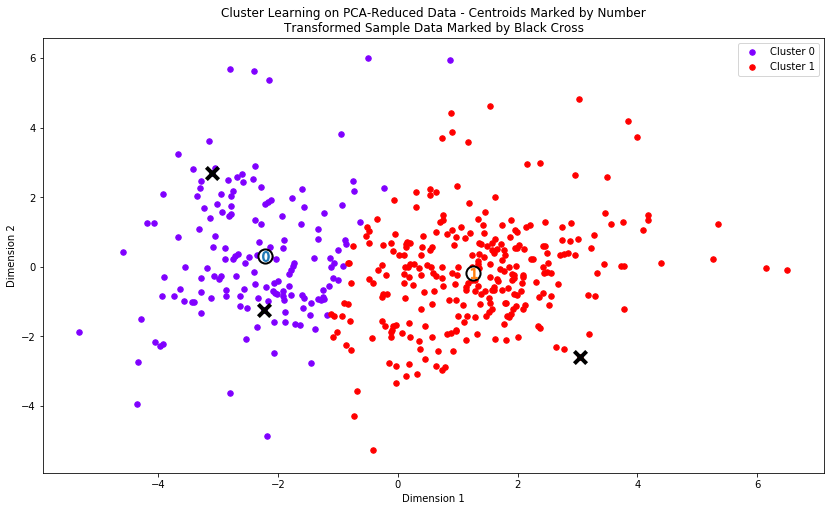

In [38]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

# Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

DBSCAN is a density based clustered algorithm similar to mean-shift, but with a couple of notable advantages. Check out another fancy graphic below and let’s get started!

![Kmeans](https://miro.medium.com/max/1350/1*tc8UF-h0nQqUfLC8-0uInQ.gif "Dbscan Ilustration")


In [0]:
from sklearn.cluster import DBSCAN

In [0]:
clusterer = DBSCAN(eps=0.3 # distance
                   ,min_samples=2) #min sample in group 
clusterer.fit(reduced_data)
preds = clusterer.fit_predict(reduced_data)

# centers = null
sample_preds = clusterer.fit_predict(pca_samples)

In [41]:
np.unique(preds, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35]),
 array([ 68,  52,   6, 190,   4,  16,   2,   3,   2,   4,   3,   3,   2,
          6,  15,   3,   2,   4,   4,   3,   2,   2,   3,   2,   4,   2,
          3,   2,   2,   3,   2,   2,   2,   2,   3,   5,   2]))

In [0]:
def cluster_results(reduced_data, preds, centers, pca_samples):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions
    Adds cues for cluster centers and student-selected sample data
    '''
    preds = abs(preds)
    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)

    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))
    grup= pd.DataFrame(preds).groupby(0).size()
    
    # Color map
    cmap = cm.get_cmap('rainbow')

    # Color the points based on assigned cluster
    
    try:
        for i, cluster in plot_data.groupby('Cluster'):   
            cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
    #                      color = cmap
                         color = cmap((i)*1.0/(len(grup)-1))
                         , label = 'Cluster %i'%(i), s=30);
    except:
        for i, cluster in plot_data.groupby('Cluster'):   
            cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
    #                      color = cmap
                         color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);
        

    try:
        # Plot centers with indicators
        for i, c in enumerate(centers):
            ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                       alpha = 1, linewidth = 2, marker = 'o', s=200);
            ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);
    except:
        pass

    # Plot transformed sample points 
    ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1]
               , s = 150
               , linewidth = 4
               , color = 'black', marker = 'x');

    # Set plot title
    ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");

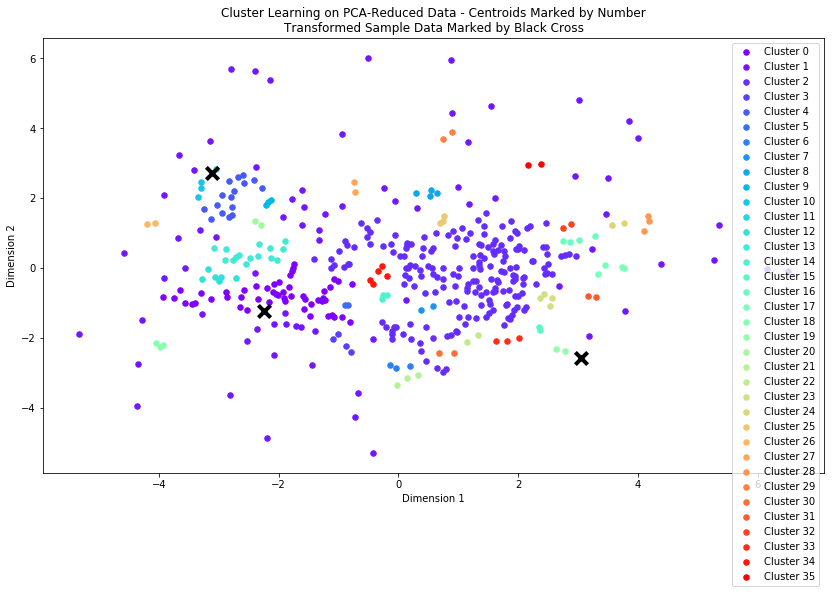

In [43]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, pca_samples=pca_samples,centers=[0,0])

# Agglomerative Hierarchical Clustering

Hierarchical clustering algorithms actually fall into 2 categories: top-down or bottom-up. Bottom-up algorithms treat each data point as a single cluster at the outset and then successively merge (or agglomerate) pairs of clusters until all clusters have been merged into a single cluster that contains all data points. Bottom-up hierarchical clustering is therefore called hierarchical agglomerative clustering or HAC. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample. Check out the graphic below for an illustration before moving on to the algorithm steps

![Agglomerative](https://miro.medium.com/max/1400/1*ET8kCcPpr893vNZFs8j4xg.gif "Dbscan Ilustration")

https://trainingdatascience.com/workshops/hierarchical-clustering---agglomerative/

In [0]:
from sklearn.cluster import AgglomerativeClustering

In [0]:
clusterer = AgglomerativeClustering(n_clusters=2,linkage='ward').fit(reduced_data)

In [46]:
# Loop through clusters
for n_clusters in range_n_clusters:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = AgglomerativeClustering(n_clusters=n_clusters,linkage='ward').fit(reduced_data)
    
    # TODO: Predict the cluster for each data point
    preds = clusterer.labels_

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='mahalanobis')
    print("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

For n_clusters = 2. The average silhouette_score is : 0.3381918715614981
For n_clusters = 3. The average silhouette_score is : 0.3484917894600557
For n_clusters = 4. The average silhouette_score is : 0.27154551683035855
For n_clusters = 5. The average silhouette_score is : 0.27346936516596215
For n_clusters = 6. The average silhouette_score is : 0.2991661994500588
For n_clusters = 7. The average silhouette_score is : 0.3085840646271011
For n_clusters = 8. The average silhouette_score is : 0.3087852073328109
For n_clusters = 9. The average silhouette_score is : 0.2997119292744004
For n_clusters = 10. The average silhouette_score is : 0.3022172480834442
For n_clusters = 11. The average silhouette_score is : 0.300859105017575
For n_clusters = 12. The average silhouette_score is : 0.29352463511168686
For n_clusters = 13. The average silhouette_score is : 0.29750237049138323
For n_clusters = 14. The average silhouette_score is : 0.30538724295992886
For n_clusters = 15. The average silhouett

## Get sample data for vizualization

In [0]:
X = reduced_data.sample(435)

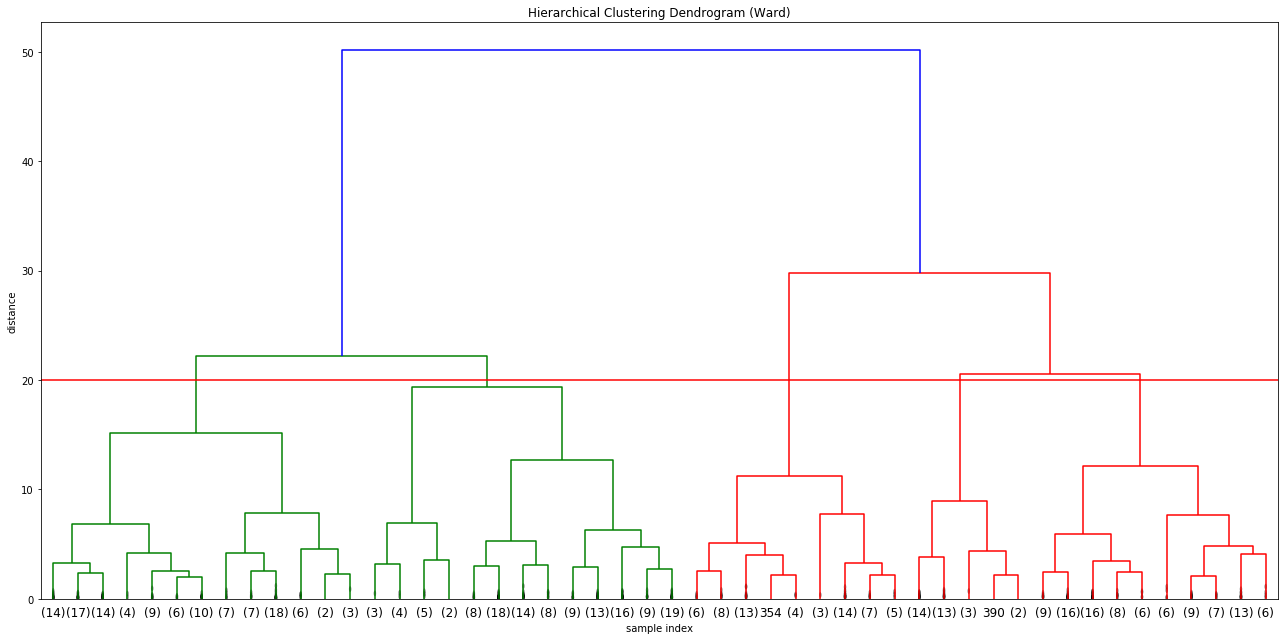

In [48]:
from scipy.cluster.hierarchy import dendrogram, linkage
linkage_matrix = linkage(X, 'ward')

figure = plt.figure(figsize=(18, 9))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=50,  # show only the last p merged clusters
    leaf_rotation=0., #label rotation
    leaf_font_size=12., #label font size
    show_contracted=True,  # to get a distribution impression in truncated branches
)


plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('sample index')
plt.ylabel('distance')
plt.axhline(y=20, color='r', linestyle='-')

plt.tight_layout()
plt.show()

# Get Best method 

## Using GMM

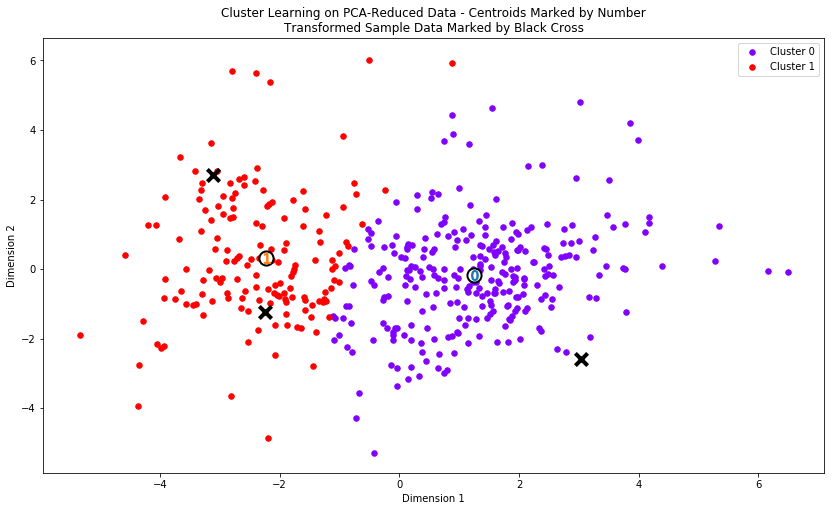

In [49]:
clusterer = GMM(n_components=2).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_
sample_preds = clusterer.predict(pca_samples)

# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

# Interpretaion

## Implementation: Data Recovery

Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the averages of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to the average customer of that segment. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:

- Apply the inverse transform to centers using pca.inverse_transform and assign the new centers to log_centers.
- Apply the inverse function of np.log to log_centers using np.exp and assign the true centers to true_centers.

In [50]:
centers

array([[ 1.2512378 , -0.18013806],
       [-2.22116886,  0.31977698]])

In [51]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = df.columns)
true_centers.index = segments
true_centers

,Frozen,Milk,Delicassen,Detergents_Paper,Grocery,Fresh
Segment 0,2075.0,2114.0,732.0,353.0,2765.0,8953.0
Segment 1,870.0,7837.0,962.0,4696.0,12219.0,3552.0


Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. What set of establishments could each of the customer segments represent?

In [52]:
# Clusters' deviation from median
display(true_centers - df.median())

# Clusters' deviation from mean
# As you can see, this is not a meaningful comparison for Segment 1 where everything is negative
display(true_centers - df.mean())

,Frozen,Milk,Delicassen,Detergents_Paper,Grocery,Fresh
Segment 0,549.0,-1513.0,-233.5,-463.5,-1990.5,449.0
Segment 1,-656.0,4210.0,-3.5,3879.5,7463.5,-4952.0


,Frozen,Milk,Delicassen,Detergents_Paper,Grocery,Fresh
Segment 0,-996.931818,-3682.265909,-792.870455,-2528.493182,-5186.277273,-3047.297727
Segment 1,-2201.931818,2040.734091,-562.870455,1814.506818,4267.722727,-8448.297727


We will be using deviations from the median, with reference to the statistical description of the dataset at the beginning of this project, since mean is sensitive to outliers and would not yield meaningful comparisons.
- Segment 0:

Establishments in this segment have above median spending on "Milk", "Grocery" and "Detergents_Paper".
This could represent restaurants and cafes.

- Segment 1:

Establishments in this segment have above median spending on "Fresh" and "Frozen".
This could represent typical retailers such as markets specializing in fresh and frozen food.
This is typical in seafood or meat markets.